In [17]:
import pandas as pd
import numpy as np
import os

import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras
from keras.utils import np_utils
from keras.applications import mobilenet_v2
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Flatten, Dense, Dropout, Conv2D, GlobalAveragePooling2D, MaxPooling2D, InputLayer, experimental
from keras.layers.experimental import preprocessing
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import seaborn as sns



In [18]:
from google.colab import drive

In [19]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
path = "/content/drive/MyDrive/image_classification"

In [21]:
#Directory of training, test and validation folders
train_dir = os.path.join(path, "data", "train")
test_dir = os.path.join(path, "data", "test")    
val_dir = os.path.join(path, "data", "val")   

In [25]:
#Directories of data
train_cardboard = os.path.join(train_dir, "cardboard")
train_glass = os.path.join(train_dir, "glass")
train_metal = os.path.join(train_dir, "metal")
train_paper = os.path.join(train_dir, "paper")
train_plastic = os.path.join(train_dir, "plastic")
train_trash = os.path.join(train_dir, "trash")

test_cardboard = os.path.join(test_dir, "cardboard")
test_glass = os.path.join(test_dir, "glass")
test_metal = os.path.join(test_dir, "metal")
test_paper = os.path.join(test_dir, "paper")
test_plastic = os.path.join(test_dir, "plastic")
test_trash = os.path.join(test_dir, "trash")

In [26]:
#Viualize some sample photos from each trash category
def random_photo(folder_names):
    source_path = os.path.join(path, 'data','train',folder_names)
    img_titles = os.listdir(source_path)
    random_img_titles = np.random.choice(img_titles, size = 1, replace = False)
    for i in random_img_titles:
        img = load_img(os.path.join(source_path, i), target_size=(224,224))
    return img

In [27]:
cardboard = random_photo('cardboard')
glass = random_photo('glass')
metal = random_photo('metal')
paper = random_photo('paper')
plastic = random_photo('plastic')
trash = random_photo('trash')

In [28]:
imgs = np.asarray([np.array(cardboard), np.array(glass), np.array(metal), np.array(paper), np.array(plastic), np.array(trash)])

In [ ]:
photo_name = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

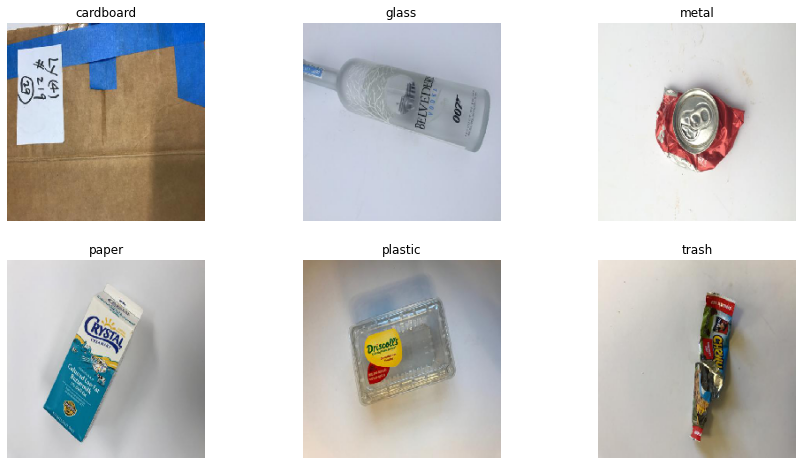

In [ ]:
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axs = axs.flatten()

i = 0
for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(photo_name[i])
    i += 1
plt.show()


In [29]:
validation_datagen_VGG = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)


test_datagen_VGG = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [30]:
directory = path + '/data/val'

validation_generator_VGG = validation_datagen_VGG.flow_from_directory(
            directory,
            target_size = (224,224),
            batch_size = 30,
            class_mode = 'categorical',
            classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
            seed = 123,
            shuffle=False)

Found 503 images belonging to 6 classes.


In [31]:
validation_generator_VGG.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [32]:
#Load the final model
vgg_source = '/content/drive/MyDrive/Colab Notebooks/image_classification/models/JULY7_VGG16_V2'

In [35]:
vgg_final = load_model(vgg_source)

In [36]:
vgg_final.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [37]:
Y_pred = vgg_final.predict(validation_generator_VGG)

y_pred = np.argmax(Y_pred, axis=1)

In [38]:
pre_outputs = pd.DataFrame(zip(y_pred, validation_generator_VGG.labels), columns = {'pred_label', 'actual_label'})

In [39]:
pre_outputs


,actual_label,pred_label
0,0,0
1,0,0
2,0,0
3,0,0
4,2,0
...,...,...
498,1,5
499,5,5
500,0,5
501,5,5


In [43]:
outputs_cardboard = pre_outputs[pre_outputs['actual_label'] == 0]
outputs_glass = pre_outputs[pre_outputs['actual_label'] == 1]
outputs_metal = pre_outputs[pre_outputs['actual_label'] == 2]
outputs_paper = pre_outputs[pre_outputs['actual_label'] == 3]
outputs_plastic = pre_outputs[pre_outputs['actual_label'] == 4]
outputs_trash = pre_outputs[pre_outputs['actual_label'] == 5]

In [51]:
outputs_plastic

,actual_label,pred_label
80,4,1
83,4,1
86,4,1
92,4,1
95,4,1
...,...,...
474,4,4
475,4,4
483,4,5
484,4,5


In [53]:
outputs_plastic[outputs_plastic['pred_label'] == 1]

,actual_label,pred_label
80,4,1
83,4,1
86,4,1
92,4,1
95,4,1
135,4,1
161,4,1
177,4,1


In [224]:
cardboard_miss_classify = outputs_cardboard.iloc[4]
glass_miss_classify = outputs_glass.iloc[0]
metal_miss_classify = outputs_metal.iloc[1]
paper_miss_classify = outputs_paper.iloc[-7]   
plastic_miss_classify = outputs_plastic.iloc[0]  
trash_miss_classify = outputs_trash.iloc[-9]

In [225]:
cardboard_miss_classify = tuple(cardboard_miss_classify)
glass_miss_classify = tuple(glass_miss_classify)
metal_miss_classify = tuple(metal_miss_classify)
paper_miss_classify = tuple(paper_miss_classify)
plastic_miss_classify = tuple(plastic_miss_classify)
trash_miss_classify = tuple(trash_miss_classify)

In [226]:
data = [cardboard_miss_classify, glass_miss_classify, metal_miss_classify, paper_miss_classify, plastic_miss_classify, trash_miss_classify]

In [231]:
missclassified_img = pd.DataFrame(data, columns = ["pred_label","actual_label"])

In [233]:
#Samples of misclassifed photos
miss_classified_photo = ["cardboard28", "glass5", "metal20","paper574", "plastic3","trash103"]


In [234]:
missclassified_img['img_title'] = miss_classified_photo

In [235]:
missclassified_img

,pred_label,actual_label,img_title
0,2,0,cardboard28
1,4,1,glass5
2,5,2,metal20
3,5,3,paper574
4,3,4,plastic3
5,0,5,trash103


In [241]:
# Load images and Convert them to a Numpy array
img1 = load_img(os.path.join(path, 'data','val','cardboard','cardboard28.jpg'), target_size=(224, 224))
img2 = load_img(os.path.join(path, 'data','val','glass','glass5.jpg'), target_size=(224, 224))
img3 = load_img(os.path.join(path, 'data','val','metal','metal20.jpg'), target_size=(224, 224))
img4 = load_img(os.path.join(path, 'data','val','paper','paper574.jpg'), target_size=(224, 224))
img5 = load_img(os.path.join(path, 'data','val','plastic','plastic3.jpg'), target_size=(224, 224))
img6 = load_img(os.path.join(path, 'data','val','trash','trash103.jpg'), target_size=(224, 224))

In [242]:
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4), np.array(img5), np.array(img6)])

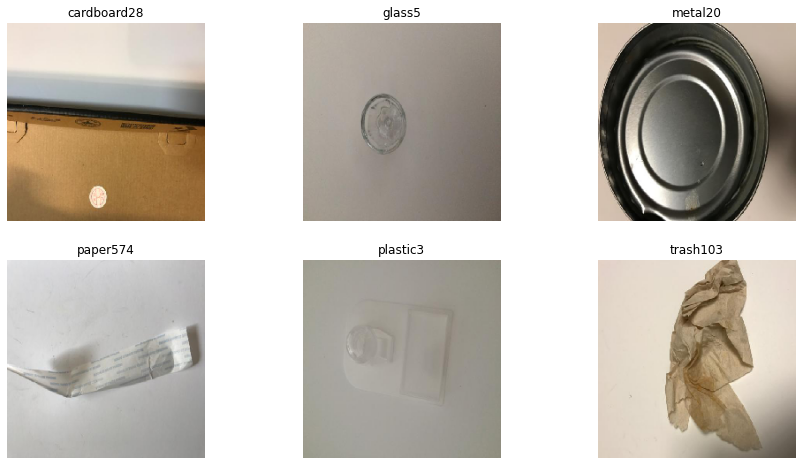

In [243]:
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axs = axs.flatten()

i = 0
for img, ax in zip(images, axs):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(miss_classified_photo [i])
    i += 1
plt.show()